Nombre:

# Práctica 6
### TDM - Máster en IoT - Rafael Caballero adaptada por Pablo C. Cañizares

Un clásico en los cursos de Machine learning es utilizar los datos del Titanic para realizar un modelo que prediga (a posteriori, claro) las posibilidades de sobrevivir al naufragio a partir de datos como la edad, el sexo, lo que se ha pagado por el pasaje, etc. 

Aquí no vamos a ser menos y utilizaremos regresión logística para intentar predecir este valor

### 1.- setup y carga de datos

Empezamos asegurándonos de que Spark está disponible y funciona y cargando funciones auxiliares

In [2]:
import os.path
from subprocess import check_call
import importlib
import os
import sys

modules = ["findspark", "pyspark", "urllib", "pyspark_dist_explore", "scikit-learn"]

if "google.colab" in sys.modules:
    !apt-get install openjdk-8-jdk-headless -qq > /dev/null
    spark = "spark-3.2.0-bin-hadoop3.2.tgz"
    if not os.path.isfile(spark):
        !wget -q https://downloads.apache.org/spark/spark-3.2.0/{spark}
        !tar xf {spark}
        os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
        os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

print("Checking required modules")
for m in modules:
    torch_loader = importlib.util.find_spec(m)
    if torch_loader is not None:
        print(m, " found")
    else:
        print(m, " not found, installing")
        if "google.colab" in sys.modules:
            check_call(["pip", "install", "-q", m])
        else:
            check_call([sys.executable, "-m", "pip", "install", "--user", m])
print("Done!")

Checking required modules
findspark  found
pyspark  found
urllib  found
pyspark_dist_explore  found
scikit-learn  not found, installing
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 2.2 MB/s eta 0:00:00a 0:00:01
Done!


**Nota** Ejecutar el siguiente código solo si es necesaripo poner variables de entorno (en el laboratorio NO)

In [3]:
"""
%matplotlib inline
import os
# cambiamos las variables del sistema
spark = 'C:/hlocal/tdm/spark/spark-3.2.0-bin-hadoop3.2'
if not(os.path.isdir(spark+"/bin")) or not(os.path.isdir(spark+"/jars")) :
        print("Error, la carpeta en 'spark' debe contener los directorios bin y jars ")
else:
        # en el path se añade
        #path = os.environ.get('PATH')
        #path = path+ ';'+spark+'\\bin;'
        #os.environ['PATH'] = path
        os.environ['SPARK_HOME']= spark
        os.environ['HADOOP_HOME']= spark
        os.environ['PYSPARK_DRIVER_PYTHON']= 'jupyter'
        os.environ['PYSPARK_DRIVER_PYTHON_OPTS']='notebook'

        # si da problema con collect quizás haya que poner java_home a la localización de java 8
        #os.environ['JAVA_HOME']= 'C:\\Program Files\\Java\\jdk1.8.0_151'
        #os.environ['PATH'] = os.environ.get('JAVA_HOME')+'\\bin;'+spark
        print("Hecho")
print("Preparado!!")
"""

'\n%matplotlib inline\nimport os\n# cambiamos las variables del sistema\nspark = \'C:/hlocal/tdm/spark/spark-3.2.0-bin-hadoop3.2\'\nif not(os.path.isdir(spark+"/bin")) or not(os.path.isdir(spark+"/jars")) :\n        print("Error, la carpeta en \'spark\' debe contener los directorios bin y jars ")\nelse:\n        # en el path se añade\n        #path = os.environ.get(\'PATH\')\n        #path = path+ \';\'+spark+\'\\bin;\'\n        #os.environ[\'PATH\'] = path\n        os.environ[\'SPARK_HOME\']= spark\n        os.environ[\'HADOOP_HOME\']= spark\n        os.environ[\'PYSPARK_DRIVER_PYTHON\']= \'jupyter\'\n        os.environ[\'PYSPARK_DRIVER_PYTHON_OPTS\']=\'notebook\'\n\n        # si da problema con collect quizás haya que poner java_home a la localización de java 8\n        #os.environ[\'JAVA_HOME\']= \'C:\\Program Files\\Java\\jdk1.8.0_151\'\n        #os.environ[\'PATH\'] = os.environ.get(\'JAVA_HOME\')+\'\\bin;\'+spark\n        print("Hecho")\nprint("Preparado!!")\n'

Comprobamos si Spark está listo...

In [4]:
import findspark

findspark.init()

import pyspark  # only run after findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext


df = spark.sql("""select 'spark' as hi """)
df.show()

24/11/05 19:03:55 WARN Utils: Your hostname, ubuntu resolves to a loopback address: 127.0.1.1; using 10.9.100.134 instead (on interface wlp0s20f3)
24/11/05 19:03:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/05 19:03:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+-----+
|   hi|
+-----+
|spark|
+-----+



Funciones útiles que ya conocemos, y nombre con el que el fichero se grabará en local

In [5]:
# file = "./titanic.csv"
file = "./titanic.csv"

from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

%matplotlib inline
import pyspark.sql.functions as func


def histogram(df, col, bins=20, color="red"):
    fig, ax = plt.subplots()
    hist(ax, df.select([col]), bins=bins, color=[color])
    plt.xlabel(col)
    vs = df.select(func.mean(col), func.stddev(col)).collect()
    mean = vs[0][0]
    sd = vs[0][1]
    median = df.agg(func.percentile_approx(col, 0.5).alias("median")).collect()[0][0]
    # print(mean,sd,median,mode)
    plt.plot([mean - 1.97 * sd, mean + 1.97 * sd], [10, 10], color="blue")
    plt.plot([mean, mean], [0, -20], color="blue")
    plt.plot([median, median], [25, -15], color="green")
    plt.title(
        "Histogram of "
        + str(col)
        + ". Median: "
        + str(round(median, 2))
        + ". Mean: "
        + str(round(mean, 2))
        + ". SD: "
        + str(round(sd, 2))
    )
    plt.show()


def prop_null_coll(df, c):
    total = df.count()
    nuls = df.filter(df[c].isNull()).count()
    prop = nuls * 100 / total
    return prop


def printnulls(df):
    for c in df.columns:
        print(f"Column {c} contains {round(prop_null_coll(df,c),2)}% nulls")
    return


def load_file(file):
    df = (
        spark.read.format("com.databricks.spark.csv")
        .options(header="true", inferschema="true")
        .load(file)
    )
    return df

24/11/05 19:04:06 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Descargamos el fichero en local

In [6]:
import urllib.request

url = "https://raw.githubusercontent.com/RafaelCaballero/tdm/master/datos/titanicyesno.csv"

f = urllib.request.urlretrieve(
    url, file
)  # in case of error download manually and comment this line
# lo cargamos como un dataframe
df = load_file(file)
print(f"{df.count()} rows")
df.printSchema()

891 rows
root
 |-- survived: string (nullable = true)
 |-- pclass: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: double (nullable = true)
 |-- sibsp: integer (nullable = true)
 |-- parch: integer (nullable = true)
 |-- ticket: string (nullable = true)
 |-- fare: double (nullable = true)
 |-- embarked: string (nullable = true)



La descripción de las columnas:

    survived - Survival ('yes' or 'no')
    pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
    name - Name
    sex - Sex
    age - Age
    sibsp - Number of Siblings/Spouses Aboard
    parch - Number of Parents/Children Aboard
    ticket - Ticket Number
    fare - Passenger Fare
    embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)


Vamos a utilizar survived como label y pclass,name,sex,age,sibsp,parch,fare para predecirla

### Pregunta 1 (1.5 puntos)

El problema  es que tanto `survived` como `sex` son de tipo string. Para convertirlos a número utilizaremos dos 
[StringIndexer](https://spark.apache.org/docs/latest/ml-features#stringindexer). Un ejemplo que puede ayudar a entender cómo funciona:

In [7]:
from pyspark.ml.feature import StringIndexer

dfPega = spark.createDataFrame(
    [(0, "a"), (1, "b"), (2, "c"), (3, "a"), (4, "a"), (5, "c")], ["id", "category"]
)
dfPega.show()


+---+--------+
| id|category|
+---+--------+
|  0|       a|
|  1|       b|
|  2|       c|
|  3|       a|
|  4|       a|
|  5|       c|
+---+--------+



In [8]:
indexer = StringIndexer(inputCol="category", outputCol="categoryIndex")  # método
indexed_model = indexer.fit(dfPega)  # metodo.fit --> modelo
df_indexed = indexed_model.transform(dfPega)  # modelo.transform --> resultado
df_indexed.show()

+---+--------+-------------+
| id|category|categoryIndex|
+---+--------+-------------+
|  0|       a|          0.0|
|  1|       b|          2.0|
|  2|       c|          1.0|
|  3|       a|          0.0|
|  4|       a|          0.0|
|  5|       c|          1.0|
+---+--------+-------------+



En nuestro caso utilizaremos 2 StringIndexer.

* El primero tendrá como columna de entrada `survived` y como columna de salida `label`
* El segundo tendrá como columna de entrada `sex`  y como columna de salida `sex_i`

Nota:

* Ponerle un nombre diferente tanto a cada método indexer como al "modelo" que generan, no reutilizar variables. 
* En caso del indexer para `label` el modelo (obtenido tras hacer fit) se llamará `indexer_model`. 
* Recordar que al final habrá que aplicar los dos modelos, uno tras otro
* El df que se obtiene tras aplicar los dos indexers se llamará `dfi`

In [10]:
from pyspark.ml.feature import StringIndexer

# solución
dfi = df

indexer_survived = StringIndexer(inputCol="survived", outputCol="label")  # método
indexed_model_survived = indexer_survived.fit(dfi)  # metodo.fit --> modelo
dfi = indexed_model_survived.transform(dfi)  # modelo.transform --> resultado

indexer_sex = StringIndexer(inputCol="sex", outputCol="sex_i")  # método
indexed_model_sex = indexer_sex.fit(dfi)  # metodo.fit --> modelo
dfi = indexed_model_sex.transform(dfi)  # modelo.transform --> resultado

Este código muestra la identificación entre etiquetas y valores en el caso de la columna `label`, y el dataframe resultante (nota: los valores asignados a las etiquetas pueden cambiar de los míos, apuntarlos para más adelante)

In [12]:
print(list(zip(indexed_model_survived.labels, [0, 1])))
dfi.select(["name", "sex", "sex_i", "survived", "label"]).show()

[('no', 0), ('yes', 1)]
+--------------------+------+-----+--------+-----+
|                name|   sex|sex_i|survived|label|
+--------------------+------+-----+--------+-----+
|Braund, Mr. Owen ...|  male|  0.0|      no|  0.0|
|Cumings, Mrs. Joh...|female|  1.0|     yes|  1.0|
|Heikkinen, Miss. ...|female|  1.0|     yes|  1.0|
|Futrelle, Mrs. Ja...|female|  1.0|     yes|  1.0|
|Allen, Mr. Willia...|  male|  0.0|      no|  0.0|
|    Moran, Mr. James|  male|  0.0|      no|  0.0|
|McCarthy, Mr. Tim...|  male|  0.0|      no|  0.0|
|Palsson, Master. ...|  male|  0.0|      no|  0.0|
|Johnson, Mrs. Osc...|female|  1.0|     yes|  1.0|
|Nasser, Mrs. Nich...|female|  1.0|     yes|  1.0|
|Sandstrom, Miss. ...|female|  1.0|     yes|  1.0|
|Bonnell, Miss. El...|female|  1.0|     yes|  1.0|
|Saundercock, Mr. ...|  male|  0.0|      no|  0.0|
|Andersson, Mr. An...|  male|  0.0|      no|  0.0|
|Vestrom, Miss. Hu...|female|  1.0|      no|  0.0|
|Hewlett, Mrs. (Ma...|female|  1.0|     yes|  1.0|
|Rice, 

### Problema 2 (1.5 puntos)

Parece que la columna `age` tiene valores nulos. Vamos a comprobar si es la única en `dfi`:

In [16]:
printnulls(dfi)

Column survived contains 0.0% nulls
Column pclass contains 0.0% nulls
Column name contains 0.0% nulls
Column sex contains 0.0% nulls
Column age contains 19.87% nulls
Column sibsp contains 0.0% nulls
Column parch contains 0.0% nulls
Column ticket contains 0.0% nulls
Column fare contains 0.0% nulls
Column embarked contains 0.22% nulls
Column label contains 0.0% nulls
Column sex_i contains 0.0% nulls



La columna `embarked` no la vamos a usar, pero `age` sí, y son muchos nulos. Decidimos rellenar estos valores con la media. Afortunadamente disponemos ya de un transformador que hace eso, llamado `Imputer` (ver [aquí](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.Imputer.html)). Por defecto ya rellena con la media como muestra este ejemplo:

In [17]:
from pyspark.ml.feature import Imputer

dfPega = spark.createDataFrame(
    [
        (1.0, float("nan")),
        (2.0, float("nan")),
        (float("nan"), 3.0),
        (4.0, 4.0),
        (5.0, 5.0),
    ],
    ["a", "b"],
)
dfPega.show()

imputer = Imputer(inputCols=["a", "b"], outputCols=["out_a", "out_b"])  # metodo
imputmodel = imputer.fit(dfPega)  # metodo.fit -> modelo

imputmodel.transform(dfPega).show()  # modelo.transform --> resultado

+---+---+
|  a|  b|
+---+---+
|1.0|NaN|
|2.0|NaN|
|NaN|3.0|
|4.0|4.0|
|5.0|5.0|
+---+---+

+---+---+-----+-----+
|  a|  b|out_a|out_b|
+---+---+-----+-----+
|1.0|NaN|  1.0|  4.0|
|2.0|NaN|  2.0|  4.0|
|NaN|3.0|  3.0|  3.0|
|4.0|4.0|  4.0|  4.0|
|5.0|5.0|  5.0|  5.0|
+---+---+-----+-----+



 Como vemos, se le pasa una lista de columnas de entrada. En nuestro caso usaremos solo `age` como entrada y genera una nueva columna `age_m` con  los  huecos cambiados por la media de los valores existentes. 

Llamaremos a la columna de salida `age_m`, y al dataframe de salida `df_m`.

In [20]:
from pyspark.ml.feature import Imputer

# solución
imputer = Imputer(inputCols=["age"], outputCols=["age_m"])  # metodo
imputmodel = imputer.fit(dfi)  # metodo.fit -> modelo

df_m = imputmodel.transform(dfi)  # modelo.transform --> resultado

El siguiente codigo nos debe decir que age_m tiene 0 nulos

In [21]:
printnulls(df_m)

Column survived contains 0.0% nulls
Column pclass contains 0.0% nulls
Column name contains 0.0% nulls
Column sex contains 0.0% nulls
Column age contains 19.87% nulls
Column sibsp contains 0.0% nulls
Column parch contains 0.0% nulls
Column ticket contains 0.0% nulls
Column fare contains 0.0% nulls
Column embarked contains 0.22% nulls
Column label contains 0.0% nulls
Column sex_i contains 0.0% nulls
Column age_m contains 0.0% nulls


### Pregunta 3 (1 punto)

Combinar en un VectorAssembler las columnas 'pclass', 'age_m', 'sibsp', 'parch', 'fare', 'sex_i' dando como salida una nueva columna `features`. Este transformador tomará el dataframe `df_m` como entrada. El dataframe de salida se debe llamar `df_feat`



In [ ]:
from pyspark.ml.feature import VectorAssembler

vectorcols = ["pclass", "age_m", "parch", "fare", "sex_i"]
# solución: enera un vector a partir de los valores
assembler = VectorAssembler(inputCols=vectorcols, outputCol="features")
df_feat = assembler.transform(df_m)

Ejecutar este código deja solo las columnas que queremos y muestra el resultado

In [23]:
df_feat = df_feat.select(["features", "label"])
df_feat.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[3.0,22.0,0.0,7.2...|  0.0|
|[1.0,38.0,0.0,71....|  1.0|
|[3.0,26.0,0.0,7.9...|  1.0|
|[1.0,35.0,0.0,53....|  1.0|
|[3.0,35.0,0.0,8.0...|  0.0|
|[3.0,29.699117647...|  0.0|
|[1.0,54.0,0.0,51....|  0.0|
|[3.0,2.0,1.0,21.0...|  0.0|
|[3.0,27.0,2.0,11....|  1.0|
|[2.0,14.0,0.0,30....|  1.0|
|[3.0,4.0,1.0,16.7...|  1.0|
|[1.0,58.0,0.0,26....|  1.0|
|[3.0,20.0,0.0,8.0...|  0.0|
|[3.0,39.0,5.0,31....|  0.0|
|[3.0,14.0,0.0,7.8...|  0.0|
|[2.0,55.0,0.0,16....|  1.0|
|[3.0,2.0,1.0,29.1...|  0.0|
|[2.0,29.699117647...|  1.0|
|[3.0,31.0,0.0,18....|  0.0|
|[3.0,29.699117647...|  1.0|
+--------------------+-----+
only showing top 20 rows



### Pregunta 4 (2 puntos)

Ahora vamos a utilizar regresión logística, con:
* Un 70% de valores para entrenar y un 30% para test. 

El método se usará sin hiperparámetros

 Hacer que el modelo quede en una variable `lrModel` y las predicciones del test en una variable `predictions`

In [ ]:
from pyspark.ml.classification import LogisticRegression

# solución
train, test = df_feat.randomSplit([0.7, 0.3])
lr = LogisticRegression()
lrModel = lr.fit(train)
predictions = lrModel.transform(test)

24/11/05 19:23:42 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Examinar los resultados de la evaluación

In [28]:
predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(5,[0,1],[1.0,29....|  0.0|[0.29755473583888...|[0.57384464312918...|       0.0|
|(5,[0,1],[1.0,39.0])|  0.0|[0.59583027336147...|[0.64470176012622...|       0.0|
|(5,[0,1],[2.0,29....|  0.0|[1.29492758856055...|[0.78498006681692...|       0.0|
|(5,[0,1],[2.0,29....|  0.0|[1.29492758856055...|[0.78498006681692...|       0.0|
|(5,[0,1],[3.0,36.0])|  0.0|[2.49436719144337...|[0.92374599454054...|       0.0|
|(5,[0,1],[3.0,49.0])|  0.0|[2.91127193667622...|[0.94840084440764...|       0.0|
|[1.0,4.0,2.0,81.8...|  1.0|[-0.2235720390174...|[0.44433864753163...|       1.0|
|[1.0,14.0,2.0,120...|  1.0|[-2.7614177778513...|[0.05944504659657...|       1.0|
|[1.0,18.0,0.0,108...|  0.0|[-0.4341346434642...|[0.39313945029996...|       1.0|
|[1.0,18.0,0.0,2

### Pregunta 5 (2 puntos)
Repite la predicción con distintos métodos de clasificacion (LogisticRegression, RandomForestClassifier). Y discute los resultados en base a su accuracy.

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# solución
lr = LogisticRegression()
lrModel = lr.fit(train)
predictions_lr = lrModel.transform(test)

rfc = RandomForestClassifier()
rfcModel = rfc.fit(train)
predictions_rfc = rfcModel.transform(test)

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_lr = evaluator.evaluate(predictions_lr)
accuracy_rfc = evaluator.evaluate(predictions_rfc)

print(f"LogisticRegression accuracy: {accuracy_lr}")
print(f"RandomForestClassifier accuracy: {accuracy_rfc}")

LogisticRegression accuracy: 0.7748091603053435
RandomForestClassifier accuracy: 0.8206106870229007


### Pregunta 6 (1 punto)

Vamos a hacer nuestra propia matriz de confusión a partir de las columnas `prediction` y `label` del dataframe `predictions`. La representaremos como un array de arrays. En nuestro caso al tener solo 2 clases tendra 4 valores como muestra el disguiente diagrama:

<img src="https://www.nbshare.io/static/snapshots/cm_colored_1-min.png" width=350>

<img src="https://www.dataschool.io/content/images/2015/01/confusion_matrix_simple2.png" width="200">

Escribir una función

- Name: cm
- Descr: Calcula la matriz de confusión a partir de las predicciones. En esta matriz las filas indican los valores reales y las columnas los predichos. Así, por ejemplo m[0][1] serán la cantidad de valores que, teniendo `label` 0 han tenido `prediction` 1.
- Param: p, un dataframe de predicciones
- Salida: la matriz de confusión

Nota: para calcular el número de valores que verifican las condiciones que deseemos se aconseja usar [filter](https://sparkbyexamples.com/pyspark/pyspark-where-filter/) seguido de count()

In [ ]:
def cm(p):
    # solucion
    m = []
    for i in range(2):
        m.append([])
        for j in range(2):
            m[i].append(p.filter(f"label = {i} and prediction == {j}").count())
    return m

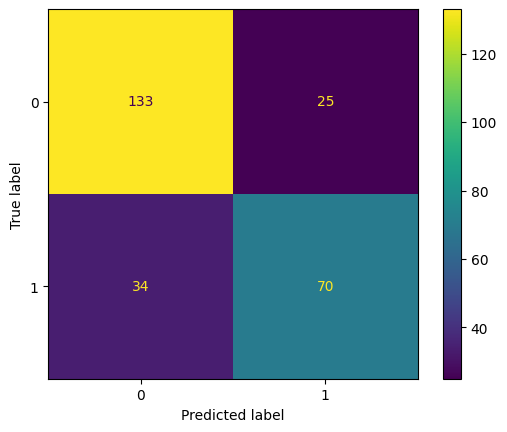

In [65]:
# test
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

m = cm(predictions)

ConfusionMatrixDisplay(np.array(m), display_labels=[0, 1]).plot()

### Pregunta 7 (1 punto)

- Vamos a llamar `precision` de una método para una etiqueta a la proporción de veces que cuando se predice esa etiqueta resulta ser real. 

- Vamos a llamar recall o exhaustividad de un método para una etiqueta al la proporción de valores reales de esa etiqueta que han sido predichos correctamente. 

Por ejemplo, dada esta matriz de confusión:

    m2 = [[20,80],
          [10,90]]
     
Tendremos:
* Accuracy(m2,0): 20/(20+10) = 0.666666
* Recall(m2,0): 20//(20+80) = 0.2
* Accuracy(m2,1): 90/(90+80) = 0.529...
* Recall(m2,1): 90//(10+90) = 0.9


Escribir dos métodos, accuracy y  recall para calcular la precisión y el recall a partir de una matriz de confusión y una etiqueta (número >=0)

In [69]:
def accuracy(m, value):
    return m[value][value] / sum((row[value] for row in m))


def recall(m, value):
    return m[value][value] / sum((col for col in m[value]))

In [70]:
# test1
m2 = [[20, 80], [10, 90]]
for i in range(2):
    print(f"Accuracy of {i}: {round(accuracy(m2,i),3)}")
    print(f"Recall of {i}: {round(recall(m2,i),3)}")


Accuracy of 0: 0.667
Recall of 0: 0.2
Accuracy of 1: 0.529
Recall of 1: 0.9


In [68]:
# test2: nuestro ejemplo

for i in range(2):
    print(f"Accuracy of {i}: {round(accuracy(m,i),3)}")
    print(f"Recall of {i}: {round(recall(m,i),3)}")

Accuracy of 0: 0.796
Recall of 0: 0.842
Accuracy of 1: 0.737
Recall of 1: 0.673
